# Final Main Code

### Created by Michael Vause, 30/12/19
#### tkinter doesn't work on macos 10.14.6 

##### Check Python Version

In [1]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


##### Main Code

In [2]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os
#from pathlib import Path
import importlib

try:
    import matlab.engine
    eng = matlab.engine.start_matlab()
    print("Matlab")
except ImportError as e:
    pass  # module doesn't exist

Matlab


In [3]:
#Any functions to go here

#Take a file path and return all the non hidden files
def non_hidden(path):
    files = []
    for file in os.listdir(path):
        if not file.startswith("."):
            files.append(file)
    return files

#Refresh examples drop down menu
def refresh_ex(command):
    new_options = []
    select_menu.children["menu"].delete(0, "end")
    old_options = non_hidden("Algorithms/"+str(alg_var.get())+"/examples")
    old_options.sort()
    old_options.append("Own Data")
    old_clone = old_options.copy()
    for example in old_clone:
        if example == "__pycache__":
            old_options.remove("__pycache__")
        elif example == "data":
            old_options.remove("data")
        elif example == "utils":
            old_options.remove("utils")
        elif example.startswith("Own_Data"):
            old_options.remove(example)
    
    for op in old_options:
        new_options.append(op)
        select_menu.children["menu"].add_command(label=op,command= lambda o=op:new_com(o))
    sel_var.set(new_options[0])
    refresh_sys("<command>")

#new command for select menu
def new_com(name):
    sel_var.set(name)
    refresh_sys("<command>")
    
#Refresh systems drop down menu
def refresh_sys(command):
    new_systems = []
    system_menu.children["menu"].delete(0, "end")
    if str(sel_var.get()) == "Own Data":
        old_systems = non_hidden("Data")
        old_systems.sort()
        for sys in old_systems:
            new_systems.append(sys)
            system_menu.children["menu"].add_command(label=sys,command= lambda s=sys:sys_var.set(s))
        sys_var.set(new_systems[0])
    else:
        sys_var.set(" ")
        
    update_param_fram()
        
#Compute button to run selected example
def comp():
    if str(sel_var.get()) == "Own Data":
        if str(alg_var.get()) == "sparsedynamics":
            to_add = "Algorithms/"+str(alg_var.get())+"/examples"
            eng.addpath(to_add)
        
            input_data = str(sys_var.get())
            [coefout,desc] = eng.Own_Data(input_data,nargout=2)
            update_matlab(coefout,desc)
        else:
            eg = "Own_Data.py"
            imp = eg.split(".py", 1)[0]
            to_run = importlib.import_module(imp)
            
            input_data = str(sys_var.get())
            
            [coef,desc] = to_run.example(input_data)
            update_out(coef,desc)
    elif str(sel_var.get()).endswith(".py"):
        eg = str(sel_var.get())
        imp = eg.split(".py", 1)[0]
        to_run = importlib.import_module(imp)
    
        [coef,desc] = to_run.example()
        update_out(coef,desc)
    elif str(sel_var.get()).endswith(".m"):        
        eg = str(sel_var.get())
        imp = eg.split(".m", 1)[0]
        imp = imp + "();"
        
        to_add = "Algorithms/"+str(alg_var.get())+"/examples"
        eng.addpath(to_add)
        
        [coefout,desc] = eng.eval(str(imp),nargout=2)
        update_matlab(coefout,desc)
    
# Update output list box and plot
def update_out(coef,desc):
    tv.delete(*tv.get_children())
    
    for item in range(len(desc)):
        new_val = []
        for col in range(len(coef[0])):
            new_val.append(str(coef[item,col]))
        tv.insert('', 'end', text=desc[item], values=new_val)
    
    plot(coef,desc)

# Update the output for the matlab examples
def update_matlab(coefout,desc):
    coeflist = [ item for elem in coefout for item in elem]
        
    num_rows = int(len(coeflist)/len(coefout[0]))
        
    for x in range(0,num_rows):
        row = np.array([[coeflist[len(coefout[0])*x]]])
        for y in range(1,len(coefout[0])):
            value = coeflist[(len(coefout[0])*x)+y]
            row = np.append(row,[[value]])
                
        row = [row]
        if (x==0):
            coef = np.array(row)
        else:
            coef = np.append(coef, row, axis = 0)
        
    update_out(coef,desc)

# Display parameters used in each example
def update_param_fram():
    module_path = os.path.abspath(os.path.join('..'))
    module_path = module_path + "/SEED/Algorithms/"+str(alg_var.get())+"/examples"
    if module_path not in sys.path:
        sys.path.append(module_path)
        
    count = 0
    
    for child in param_fram.winfo_children():
        if count > 0:
            child.destroy()
        count = count + 1
    
    eg = str(sel_var.get())
    
    if eg == "Own Data":
        variables = []
        values = []
    elif eg.endswith(".py"):
        imp = eg.split(".py", 1)[0]
        to_run = importlib.import_module(imp)
        [variables,values] = to_run.get_params()
    elif eg.endswith(".m"):
        imp = eg.split(".m", 1)[0]
        imp = imp + "(1);"
        to_add = "Algorithms/"+str(alg_var.get())+"/examples"
        eng.addpath(to_add)
        [variables,values] = eng.eval(str(imp),nargout=2)
    
    height = len(variables)
    for i in range(height):
        var_text = variables[i]
        var_box = tk.Label(param_fram, text=var_text, font=("Times",15), bg=bgc)
        var_box.grid(row=(i+1), column=1)
        
        val_text = values[i]
        val_box = tk.Label(param_fram, text=val_text, font=("Times",15), bg=bgc)
        val_box.grid(row=(i+1), column=2)

# Plotting function
def plot(coef,desc):
    plt.clf()
    rows = len(coef)
    dims = len(coef[0])
    
    for dim in range(dims):
        coef_plt = []
        desc_plt = []
        for num in range(rows):
            row = coef[num]
            val = row[dim]
            des = desc[num]
            if val != 0:
                coef_plt.append(val)
                desc_plt.append(des)
        if 2*len(coef_plt) > 10:
            canvas.get_tk_widget().config(width=(170*len(coef_plt)))
            fig2.set_figwidth(2*len(coef_plt))
        else:
            canvas.get_tk_widget().config(width=(870))
            fig2.set_figwidth(12)
            window.geometry("1350x780")
        plt.subplot(dims,1,(dim+1))
        plt.bar(desc_plt,coef_plt)
        
        #plt.grid(True, which='both')
        plt.axhline(y=0, color='k')

    # just plt.draw() won't do it here, strangely
    plt.gcf().canvas.draw()
    

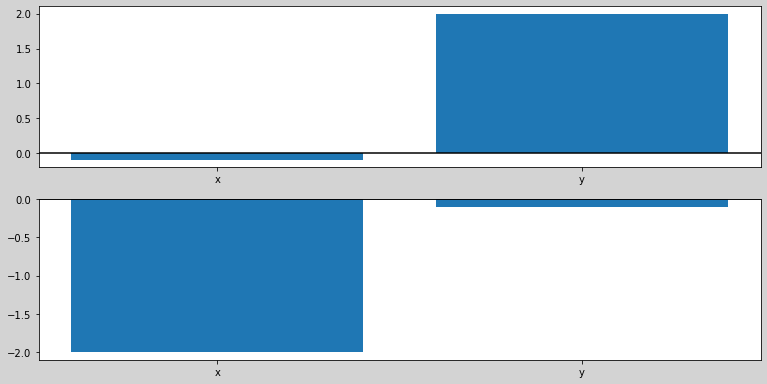

In [4]:
bgc = "lightgray"#"LightSkyBlue"#

#GUI window
window = tk.Tk()
window.title("Extracting Equations from Data")
window.minsize(1350,780)
window.config(bg=bgc)
#window.resizable(False, False)  #optional

#Add all the Labels
main_label = tk.Label(window,text="Extracting Equations from Data",font=("Times",35,"bold","underline"),padx=5,pady=10,bg=bgc)
main_label.grid(row=0,column=0,rowspan=2,columnspan=4)

algorithm_label = tk.Label(window,text="Algorithm Select:",font=("Times",15,"bold"),pady=10,bg=bgc)
algorithm_label.grid(row=2,column=0,sticky="E")

select_label = tk.Label(window,text="Example/Own Data:",font=("Times",15,"bold"),pady=10,bg=bgc)
select_label.grid(row=3,column=0,sticky="E")

system_label = tk.Label(window,text="Input Data:",font=("Times",15,"bold"),pady=10,bg=bgc)
system_label.grid(row=4,column=0,sticky="E")

#Creating dropdowns & variables
alg_var = tk.StringVar(window)
alg_options = non_hidden("Algorithms")
alg_options.sort()
alg_var.set(alg_options[0])

algorithm_menu = tk.OptionMenu(window,alg_var,*alg_options,command=refresh_ex)
algorithm_menu.config(width=30,font=("Times",15),bg=bgc)
algorithm_menu.grid(row=2,column=1,columnspan=3,sticky="nsew")
     
sel_var = tk.StringVar(window)
sel_options = non_hidden("Algorithms/"+str(alg_var.get())+"/examples")
if "__pycache__" in sel_options:
    sel_options.remove("__pycache__")
for example in sel_options:
    if example.startswith("Own_Data"):
        sel_options.remove(example)
sel_options.sort()
sel_options.append("Own Data")
sel_var.set(sel_options[0])

select_menu = tk.OptionMenu(window,sel_var,*sel_options,command=refresh_sys)
select_menu.config(width=30,font=("Times",15),bg=bgc)
select_menu.grid(row=3,column=1,columnspan=3,sticky="nsew")

sys_var = tk.StringVar(window)
sys_options = [" "]
sys_var.set(" ")

system_menu = tk.OptionMenu(window,sys_var,*sys_options)
system_menu.config(width=30,font=("Times",15),bg=bgc)
system_menu.grid(row=4,column=1,columnspan=3,sticky="nsew")

#refresh_sys("<command>")

#Add all algorithm paths to software
to_add = alg_options

if "Own Data" in to_add:
    to_add.remove("Own Data")

for alg in to_add:
    module_path = os.path.abspath(os.path.join('..'))
    module_path = module_path + "/SEED/Algorithms/"+str(alg)
    if module_path not in sys.path:
        sys.path.append(module_path)

#Parameter Frame
param_fram = tk.Frame(window,bg=bgc,bd=2,relief="sunken",pady=10)

#Add variable selection to frame, 1st 5 lines just for development
t="Parameters"
param_label1 = tk.Label(param_fram,text=t,font=("Times",15,"bold"),bg=bgc,width=62)
param_label1.grid(row=0,column=0,columnspan=4,sticky="nsew")

param_fram.grid(row=5,column=0,rowspan=2,columnspan=4,padx=5,pady=10,sticky="NW")

refresh_sys("<command>")

#Filename frame
file_fram = tk.Frame(window,bg=bgc,bd=2,relief="sunken",pady=10)

name = tk.Label(file_fram,text=" ",font=("Times",15),width=61,highlightbackground=bgc,bg=bgc)
name.grid(row=0,column=0,columnspan=4)

comp_but = tk.Button(file_fram,text="Compute",command=comp,font=("Times",15,"bold"),width=20,highlightbackground=bgc)
comp_but.grid(row=1,column=1,columnspan=2,sticky="EW")

name1 = tk.Label(file_fram,text=" ",font=("Times",15),width=61,highlightbackground=bgc,bg=bgc)
name1.grid(row=2,column=0,columnspan=4)

file_fram.grid(row=7,column=0,rowspan=3,columnspan=4,padx=5,sticky="SEW")

#Add frame for output values title & textbox
fig1_fram = tk.Frame(window,bd=2,bg=bgc)

fig1_label = tk.Label(fig1_fram,text="Coefficient Values",font=("Times",18,"bold"),pady=10,bg=bgc)
fig1_label.grid(row=0,column=0,sticky="W")

output_scroll = tk.Scrollbar(fig1_fram)
output_scroll.grid(row=1,column=1,rowspan=4,sticky="nsew")

tv = ttk.Treeview(fig1_fram, yscrollcommand = output_scroll.set)
tv['columns'] = ('col1', 'col2', 'col3')
tv.heading("#0", text='Descriptor', anchor='w')
tv.column("#0", anchor="w")
tv.heading('col1', text='Equation One')
tv.column('col1', anchor='center')
tv.heading('col2', text='Equation Two')
tv.column('col2', anchor='center')
tv.heading('col3', text='Equation Three')
tv.column('col3', anchor='center')
tv.grid(row=1,column=0)#sticky = (N,S,W,E))

output_scroll.config(command = tv.yview)

fig1_fram.grid(row=0,column=4,rowspan=5,padx=5,sticky="W")

#Add frame for output graph title & plot
fig2_fram = tk.Frame(window,bd=2,bg=bgc)

fig2_label = tk.Label(fig2_fram,text="Coefficient Plot",font=("Times",18,"bold"),pady=10,bg=bgc)
fig2_label.grid(row=0,column=0,sticky="W")

fig2 = plt.figure()
fig2.set_figheight(6.5)
fig2.set_figwidth(12)
fig2.add_subplot(111)
fig2.patch.set_facecolor(bgc)
fig2.subplots_adjust(left=0.07)
canvas = FigureCanvasTkAgg(fig2, fig2_fram)
canvas.get_tk_widget().grid(row=1,column=0,sticky="NW")
canvas.get_tk_widget().configure(background=bgc)

fig2_fram.grid(row=6,column=4,rowspan=2,padx=5,sticky="NW")

#Enter mainloop
window.mainloop()

In [5]:
eng.quit()